## <p style="text-align: center">  Extracting features</p>

**Author:**  Carl Toews    
**File:  ** extract_features.ipynb  

### Description:

In order to implement machine learning algorithms, we need to develop a set of informative features.  Following *Machine learning for predicting professional tennis matches* [Sipko, 2015], for each match we assign one player to be "Player 0" and the other to be "Player 1", and call the outcome a 0 if Player 0 won and a 1 otherwise.  For each match, we produce a set of features, each a measure of *difference* between some characteristic of the two players.  The characteristics we consider include the following (many  of these are from Sipko):

* rank:  rank  
* rankpts:  rank points  
* height:  height  
* hand: handedness binary (0 for right, 1 for left)
* fsp:  "first serve is valid" (percentage)
* wfs:  winning first serve (percentage)  
* wss: winning second serve (percentage )
* wsp:  winning on *any* serve (percentage)
* wrp:  winning on returns (percentage) 
* tpw:  total points won (percentage)
* acpg: average number of aces (per game)  
* dfpg:  average number of double faults (per game) 
* bps: break points saved (percentage)
* tmw: total matches won (percentage)
* retired: binary (`True` if 1st match back since retirement)
* fatigue: fatigue score (based on number of matches in past 3 days)
* complete: player completeness score (Sipko)
* serveadv: score to measure the relative advantage when serving  
* direct:  head to head balance with a particular player  

Note that rank, rankpts, height, and hand can be read from player data directly with no calculation.  On the other hand, fsp, wfs, wss, wsp, wrp, tpw, acpg, dfpg, bps can be calculated for any given match, but for purposes of predicting a future match, need to be averaged over the historical record.  Finally, tmw, retired, fatigue, complete, serveadv, and direct are  not calculated "match-by-match", but rather derived from the historical record. 

In order to derive these features, we'll first need to clean the data a bit.  Specifically, we need to deal with missing or null values, as well as rectify incorrect values.  Examples of issues include:  
*  The 'score' column contains inconsistent strings for indicating irregular outcomes
*  Many matches don't include statistics such as ace rates, double faults, etc.
 

# I.  Data extraction

Import statements

In [474]:
import sqlalchemy # pandas-mysql interface library
import sqlalchemy.exc # exception handling
from   sqlalchemy import create_engine  # needed to define db interface
import sys # for defining behavior under errors
import numpy as np # numerical libraries
import scipy as sp
import pandas as pd # for data analysis
import pandas.io.sql as sql # for interfacing with MySQL database
import matplotlib as mpl # a big library with plotting functionality
import matplotlib.pyplot as plt # a subset of matplotlib with most of the useful tools
import IPython as IP
%matplotlib inline 
import pdb
#%qtconsole

Player and odds data from 2010-2016 has beeen matched and stored.  Retrieve, merge, and rename.

In [973]:
pickle_dir = '../pickle_files/'
odds_file = 'odds.pkl'
matches_file = 'matches.pkl'

odds= pd.read_pickle(pickle_dir + odds_file)
matches= pd.read_pickle(pickle_dir + matches_file)
data = pd.merge(matches,odds[['PSW','PSL','key']],how='inner',on='key')

Get additional training data.  We'll include data from 2005, excluding Davis Cup matches, and focusing exclusively on players who played in our 2010-2016 set.

In [1710]:
# name of database
db_name = "tennis"
# name of db user
username = "testuser"
# db password for db user
password = "test623"
# location of atp data files
atpfile_directory = "../data/tennis_atp-master/"

# focus on most recent data; exclude Davis Cup stuff
startdate = '20050101'
enddate = '20161231'

engine = create_engine('mysql+mysqldb://' + username + ':' + password + '@localhost/' + db_name)
    
# get unique winners and losers in our set
players = tuple(pd.concat((data.winner_id,data.loser_id)).unique())

# load all data pertinant for any player
with engine.begin() as connection:
    matches_hist = pd.read_sql_query("""SELECT * FROM matches \
    WHERE tourney_date >= '""" + startdate + """' \
    AND tourney_date <= '""" + enddate + """' \
    AND (winner_id IN %(p)s \
    OR loser_id IN %(p)s) \
    AND tourney_name NOT LIKE 'Davis%%';""",connection,params={'p':players})  

# II. Calculate match statistics

Many of the features we will develop will involve quantities derived from previous matches.  Examples include weighted historical averages of winning first serves, double faults, etc.  This section calculates some important quantities for each match.

*Insert index on `matches_hist`*

In [1711]:
matches_hist['key'] = np.arange(len(matches_hist))

*Extract text string indicating unusual match outcomes*

In [1712]:
# scores are just numbers, unless something weird happened.  Extract comments about irregular outcomes.  
t=matches_hist.score.str.extractall('(?P<comment>[a-zA-Z]+.+)').xs(0,level='match')
matches_hist = pd.merge(matches_hist,t,how='outer',left_index=True, right_index=True)
matches_hist.comment.unique()

array([nan, 'W/O', 'RET', 'DEF', 'Jun'], dtype=object)

*Calculate games scores for each set, store in a separate dataframe*

In [1713]:
# discard comments and trailing white space
scores = matches_hist.score.str.replace('(?P<comment>[a-zA-Z]+.+)','')
scores = scores.str.replace('(?P<comment>\([0-9]+\))','').str.strip()

# split the game scores into columns of a dataframe
scores = scores.str.split('-|\s',expand=True)
scores.columns=['W1','L1','W2','L2','W3','L3','W4','L4','W5','L5']
scores = scores.apply(lambda x: pd.to_numeric(x))

*Store the number of games played in each match.*

In [1714]:
ngames = np.sum(scores,axis=1)
matches_hist.insert(0,'ngames',ngames.astype('int'))

It seems a few matches were cut short for no recorded reason:

In [1715]:
# sanity check:  are matches involving few than 12 games identical to those with commments?
idx1 = (ngames<12)
idx2 = matches_hist.comment.notnull()
z=(idx1*1)*(idx2*1-1)
zz = np.where(np.abs(z))[0]
print("matches with weird outcomes:  ")
print(matches_hist.loc[zz,'score'])

matches with weird outcomes:  
6018     6-3 1-1
7245     6-3 1-0
7286        None
7466         4-0
7937     6-3 1-0
19303        4-1
Name: score, dtype: object


*Calcuate **first serve percentages (fsp)** for both winners and losers.*

In [1716]:
matches_hist.insert(0,'w_fsp',matches_hist.w_1stIn/matches_hist.w_svpt)
matches_hist.insert(0,'l_fsp',matches_hist.l_1stIn/matches_hist.l_svpt)
matches_hist.loc[matches_hist.]

*Calculate **winning first serve percentages (wfs)***

In [1717]:
matches_hist.insert(0,'w_wfs',matches_hist.w_1stWon/matches_hist.w_svpt)
matches_hist.insert(0,'l_wfs',matches_hist.l_1stWon/matches_hist.l_svpt)

*Calculate **second serves in (2ndIn)** for both winners and losers*

In [1718]:
matches_hist.insert(0,'w_2ndIn',matches_hist.w_svpt-matches_hist.w_df-matches_hist.w_1stIn)
matches_hist.insert(0,'l_2ndIn',matches_hist.l_svpt-matches_hist.l_df-matches_hist.l_1stIn)

*Calculate **second serve (ssp)** percentages *

In [1719]:
matches_hist.insert(0,'w_ssp',matches_hist.w_2ndIn/(matches_hist.w_2ndIn+matches_hist.w_df))
matches_hist.insert(0,'l_ssp',matches_hist.l_2ndIn/(matches_hist.l_2ndIn+matches_hist.l_df))

*Calculate **wining second serve percentages (wss)***

In [1720]:
matches_hist.insert(0,'w_wss',matches_hist.w_2ndWon/matches_hist.w_2ndIn)
matches_hist.insert(0,'l_wss',matches_hist.l_2ndWon/matches_hist.l_2ndIn)

*Calculate **overall win on serve percentages (wsp)***

In [1860]:
#matches_hist.insert(0,'w_wsp',(matches_hist.w_1stWon + matches_hist.w_2ndWon)/matches_hist.w_svpt)
#matches_hist.insert(0,'l_wsp',(matches_hist.l_1stWon+matches_hist.l_2ndWon)/matches_hist.l_svpt)
matches_hist['w_wsp']=(matches_hist.w_1stWon + matches_hist.w_2ndWon)/matches_hist.w_svpt
matches_hist['l_wsp']=(matches_hist.l_1stWon+matches_hist.l_2ndWon)/matches_hist.l_svpt

*Calculate **winning on return percentages (wrp)**.*  

[(# of opponent serves) - (# of opponent service victories)]/(# of opponent serves)

In [1722]:
matches_hist.insert(0,'w_wrp',(matches_hist.l_svpt - matches_hist.l_1stWon \
                               - matches_hist.l_2ndWon)/(matches_hist.l_svpt))
matches_hist.insert(0,'l_wrp',(matches_hist.w_svpt - matches_hist.w_1stWon \
                              - matches_hist.w_2ndWon)/(matches_hist.w_svpt))

*Calculate **total points won percentage (tpw)***

In [1723]:
matches_hist.insert(0,'w_tpw',(matches_hist.l_svpt\
                          -matches_hist.l_1stWon-matches_hist.l_2ndWon\
                          +matches_hist.w_1stWon +matches_hist.w_2ndWon)/\
                        (matches_hist.l_svpt + matches_hist.w_svpt))
matches_hist.insert(0,'l_tpw',(matches_hist.w_svpt\
                        -matches_hist.w_1stWon-matches_hist.w_2ndWon\
                        +matches_hist.l_1stWon +matches_hist.l_2ndWon)/\
                        (matches_hist.l_svpt + matches_hist.w_svpt))

*Calculate **double faults per game (dfpg)**, per game*

There are a couple of bad entries for SvGms.  We'll first fix those.  (Note:  the fix evenly partions total games between both players.  This could result in a fractional number of service games. My hunch is the total effect on the stats is minimal.)

In [1828]:
idx = np.where(((matches_hist.w_SvGms == 0)|(matches_hist.l_SvGms==0)) & (matches_hist.ngames >1))
print(matches_hist.loc[idx[0],['w_df','l_df','w_SvGms','l_SvGms','score','ngames']])
matches_hist.loc[idx[0],'w_SvGms'] = matches_hist.ngames[idx[0]]/2
matches_hist.loc[idx[0],'l_SvGms'] = matches_hist.ngames[idx[0]]/2     
print(matches_hist.loc[idx[0],['w_df','l_df','w_SvGms','l_SvGms','score','ngames']])


       w_df  l_df  w_SvGms  l_SvGms        score  ngames
2956    4.0   2.0      0.0      0.0      6-3 6-3      18
9664    2.0  12.0     16.0      0.0  6-3 6-4 7-5      31
12770   0.0   0.0      0.0      4.0  6-2 6-2 6-1      23
18690   3.0   0.0     12.0      0.0      7-5 7-5      24
18695   1.0   0.0      9.0      0.0      6-3 6-3      18
       w_df  l_df  w_SvGms  l_SvGms        score  ngames
2956    4.0   2.0      9.0      9.0      6-3 6-3      18
9664    2.0  12.0     15.5     15.5  6-3 6-4 7-5      31
12770   0.0   0.0     11.5     11.5  6-2 6-2 6-1      23
18690   3.0   0.0     12.0     12.0      7-5 7-5      24
18695   1.0   0.0      9.0      9.0      6-3 6-3      18


In [1851]:
matches_hist.insert(0,'w_dfpg',matches_hist.w_df/matches_hist.w_SvGms)
matches_hist.insert(0,'l_dfpg',matches_hist.l_df/matches_hist.l_SvGms)
#matches_hist['w_dfpg']=matches_hist.w_df/matches_hist.w_SvGms
#matches_hist['l_dfpg']=matches_hist.l_df/matches_hist.l_SvGms

*Calculate **aces per game (acpg)**, per game*

In [1855]:
matches_hist.insert(0,'w_acpg',matches_hist.w_ace/matches_hist.w_SvGms)
matches_hist.insert(0,'l_acpg',matches_hist.l_ace/matches_hist.l_SvGms)
#matches_hist['w_acpg']=matches_hist.w_ace/matches_hist.w_SvGms
#matches_hist['l_acpg']=matches_hist.l_ace/matches_hist.l_SvGms

*Calculate **break points saved percentage (bpsp)***

In [ ]:
matches_hist.insert(0,'w_bps',matches_hist.w_bpSaved/matches_hist.w_bpFaced)
matches_hist.insert(0,'l_bps',matches_hist.l_bpSaved/matches_hist.l_bpFaced)

*Flag **games with premature closure, probably due to injury (retired)***

In [1727]:
matches_hist.insert(0,'retired',0)
matches_hist.loc[(matches_hist.comment=='RET'),'retired']=1

*Flag **games won as a walkover (wo)***

In [1728]:
matches_hist.insert(0,'walkover',0)
matches_hist.loc[(matches_hist.comment=='W/O'),'walkover']=1

*Calculate player **completeness (complete)**, defined as*
$$
wsp \times wrp
$$

**Note:** *might be more useful to aggregate first, rather than compute on a per-match basis.*

In [1738]:
matches_hist.insert(0,'w_complete',matches_hist.w_wsp*matches_hist.w_wrp)
matches_hist.insert(0,'l_complete',matches_hist.l_wsp*matches_hist.l_wrp)

*Calculate player **service advantage (serveadv)**, defined as*

$$
wsp_1 -wrp_2
$$

**Note:** *as with **complete**, it might be more useful to aggregated first*

In [1739]:
matches_hist.insert(0,'w_serveadv',matches_hist.w_wsp-matches_hist.l_wrp)
matches_hist.insert(0,'l_serveadv',matches_hist.l_wsp-matches_hist.w_wrp)

*Sanity check:  investigate calculated quantities*

In [1861]:
idx = matches_hist.comment.isnull()
labels = ['dfpg', 'acpg', 'tpw', 'wrp', 'wsp', 'wss', 'wfs', 'fsp', 'ssp', 'bps','complete']
for label in labels:
    printstr = label + ": max for winner/loser is {:5.2f}/{:5.2f}, min for winner/loser is {:5.2f}/{:5.2f}"
    v1 = eval('matches_hist.w_' + label + '[idx].max()')
    v2 = eval('matches_hist.l_' + label + '[idx].max()')
    v3 = eval('matches_hist.w_' + label + '[idx].min()')
    v4 = eval('matches_hist.l_' + label + '[idx].min()')
    print(printstr.format(v1,v2,v3,v4))

dfpg: max for winner/loser is  1.44/ 2.00, min for winner/loser is  0.00/ 0.00
acpg: max for winner/loser is  2.80/ 2.55, min for winner/loser is  0.00/ 0.00
tpw: max for winner/loser is  0.79/ 0.56, min for winner/loser is  0.44/ 0.21
wrp: max for winner/loser is  0.82/ 0.53, min for winner/loser is  0.15/ 0.00
wsp: max for winner/loser is  1.00/ 0.85, min for winner/loser is  0.47/ 0.18
wss: max for winner/loser is  1.00/ 1.00, min for winner/loser is  0.00/ 0.00
wfs: max for winner/loser is  0.84/ 0.74, min for winner/loser is  0.22/ 0.08
fsp: max for winner/loser is  1.00/ 1.00, min for winner/loser is  0.29/ 0.24
ssp: max for winner/loser is  1.00/ 1.00, min for winner/loser is  0.25/ 0.36
bps: max for winner/loser is  1.00/ 1.00, min for winner/loser is  0.00/ 0.00
complete: max for winner/loser is  0.63/ 0.25, min for winner/loser is  0.11/ 0.00


# III.  Calculate features


Each feature generally requires some calculation.  We'll use the bigger data set `matches_hist` to drive the calculations, and store the results in a data frame called `features`, of the same size as `data`.

*Extract winner and loser data separately and concatenate into dataframe `all_records` with uniform column names.*

In [1862]:
# extract winner stats
w_records = matches_hist[['winner_id',
                          'tourney_date',
                          'tourney_id',
                          'match_num',
                          'ngames',
                          'key',
                          'w_acpg', # avg. no of aces per game
                          'w_dfpg', # avg no. of double faults per game
                          'w_tpw',  # total points won
                          'w_wrp',  # wining return percent
                          'w_wsp',  # winning service percent
                          'w_wss',  # winning second serve percent
                          'w_wfs',  # winning first serve percent
                          'w_fsp',  # good first serves percent
                          'w_ssp',  # good second serves percent
                          'w_bps',  # breakpoints saved percent 
                          'retired',# 1 if loser retired prematurely
                          'walkover', # 1 if loser didn't show up
                          'surface', # 'Hard', 'Clay', or 'Grass'
                          'winner_age',  # age
                          'winner_ht',   # height
                          'winner_rank', # rank
                          'winner_rank_points' # rank points
                         ]]

# rename columns
newcols = {'winner_id':'pid', 
           'tourney_date':'date',
           'tourney_id':'tid',
           'match_num':'mid',
           'ngames':'ngames',
           'key':'key',
           'w_acpg':'acpg',
           'w_dfpg':'dfpg',
           'w_tpw':'tpw',
           'w_wrp':'wrp',
           'w_wsp':'wsp',
           'w_wss':'wss',
           'w_wfs':'wfs',
           'w_fsp':'fsp',
           'w_ssp':'ssp',
           'w_bps':'bps',
           'retired':'retired',
           'walkover':'walkover',
           'surface':'surface',
           'winner_age':'age',  
           'winner_ht':'ht',   
           'winner_rank':'rank', 
           'winner_rank_points':'rank_points'
          }
w_records = w_records.rename(columns = newcols)

# record that the outcome was a victory for these players
w_records['outcome'] = np.ones(len(w_records))

# extract loser stats
l_records = matches_hist[['loser_id',
                          'tourney_date',
                          'tourney_id',
                          'match_num',
                          'ngames',
                          'key',
                          'l_acpg', # avg. no of aces per game
                          'l_dfpg',  # avg no. of double faults per game
                          'l_tpw',  # total points won
                          'l_wrp',  # wining return percent
                          'l_wsp',  # winning service percent
                          'l_wss',  # winning second serve percent
                          'l_wfs',  # winning first serve percent
                          'l_fsp',  # percent of successful first serves
                          'l_ssp',  # percent of successful second serves
                          'l_bps',  # percent of breakpoints saved  
                          'retired',# 1 if loser retired prematurely
                          'walkover',# 1 if loser didn't show up
                          'surface', # 'Hard', 'Clay', or 'Grass'
                          'loser_age',  # age
                          'loser_ht',   # height
                          'loser_rank', # rank
                          'loser_rank_points' # rank points
                         ]]

# rename columns
newcols = {'loser_id':'pid', 
           'tourney_date':'date',
           'tourney_id':'tid',
           'match_num':'mid',
           'ngames':'ngames',
           'key':'key',
           'l_acpg':'acpg',
           'l_dfpg':'dfpg',
           'l_tpw':'tpw',
           'l_wrp':'wrp',
           'l_wsp':'wsp',
           'l_wss':'wss',
           'l_wfs':'wfs',
           'l_fsp':'fsp',
           'l_ssp':'ssp',
           'l_bps':'bps', 
           'retired':'retired',
           'walkover':'walkover',
           'surface':'surface',
           'loser_age':'age',  
           'loser_ht':'ht',   
           'loser_rank':'rank', 
           'loser_rank_points':'rank_points'
          }
l_records = l_records.rename(columns = newcols)

# record outcome as a loss
l_records['outcome'] = np.zeros(len(w_records))

# fuse all the data into one dataframe
all_records = pd.concat([w_records,l_records]).reset_index().sort_values(['key']).replace(np.inf,np.nan)

*Calculate surface weighting matrix.  Note that the resulting values are quite different from Sipko's.*

In [1863]:
grouped = all_records.groupby(['pid','surface'])
t=grouped['outcome'].mean()
surf_wt = t.unstack(level=-1).corr()
surf_wt

surface,Carpet,Clay,Grass,Hard
surface,,,,
Carpet,1.000000,0.342744,0.295605,0.506449
Clay,0.342744,1.000000,0.363446,0.466821
Grass,0.295605,0.363446,1.000000,0.548772
Hard,0.506449,0.466821,0.548772,1.000000


*Function to calculate static features.  (Specifically, calculate normalized **rank, rankpts, age, height, hand** features for every match in the dataset.  Operates on the data as a whole, rather than by line.)*

In [1914]:
def  get_static_features(data):
    """
    Description: returns differences of those features that don't depend on match histories. 
    (Rank, Rankpoints, Height, Hand)
    
    Input:  dataframe with all the match data for which features are to be calculated
    Output:  another dataframe of the same length but only four columns, each with one feature
    """
    
    # boolean, 1 means (winner,loser) are (player1,player2), 0 means the reverse
    outcome = data['outcome'] 
    
    # features dataframe should include merge identifiers
    features = data[['outcome','key']].copy()
    
    # rank (normalize)
    rank=(data.loser_rank-data.winner_rank)*(-1)**outcome
    features.insert(0,'rank',rank/rank.std())

    # rank points (normalize)
    rankpts = (data.loser_rank_points-data.winner_rank_points)*(-1)**outcome
    features.insert(0,'rankpts',rankpts/rankpts.std())

    # height (normalize)
    height = (data.loser_ht-data.winner_ht)*(-1)**outcome
    features.insert(0,'height',height/height.std())   
    
    # age (normalize)
    height = (data.loser_age-data.winner_age)*(-1)**outcome
    features.insert(0,'age',height/height.std())  
    
    # hand (1 for right, 0 for left)
    hand = ((data.loser_hand=='R')*1-(data.winner_hand=='R')*1)*(-1)**outcome
    hand.iloc[np.where((data['winner_hand']=='U')|\
                      (data['loser_hand']=='U'))[0]]=np.nan
    features.insert(0,'hand',hand)
    
    return features
    

*Function to get dynamic features (i.e. all features that require some time averaging.)*

In [1894]:
def get_dynamic_features(x):
    """
    Input:  a row of the dataframe.  Needs to have the following fields:
        pid (player id number)
        tid (tournament id number)
        mid (match id number)
        date (match date)
        surface (match surface)
    Output: a dataframe of two columns, one a time discount, the other a surface discount 
    
    """
        
    # extract identifiers and date from input row
    pid = x['pid'] # player id 
    tid = x['tid'] # tourney id
    mid = x['mid'] # match id
    date = x['date']
    surface = x['surface']
    
    # extract all historical records for this player, from before this match
    records = all_records.loc[(all_records.pid==pid) & (all_records.date <= date) &\
                         ((all_records.tid != tid) | (all_records.mid != mid)),:].copy()
    
    # get time discount factor
    p = 0.8 
    t = (date - records.date).apply(lambda x: x.days/365)
    t_wt = p**t
    t_wt.loc[t_wt>p]=p
    
    # get surface discount factor
    s_wt = records.surface.apply(lambda x: surf_wt.loc[x,surface])

    # get time and court weighted averages of serve and performance stats
    t = records[['dfpg','acpg','tpw','wrp','wsp',\
              'wss','wfs','fsp','ssp','bps']].mul(t_wt*s_wt,axis=0).sum(axis=0)/\
        records[['dfpg','acpg','tpw','wrp','wsp',\
              'wss','wfs','fsp','ssp','bps']].notnull().mul(t_wt*s_wt,axis=0).sum(axis=0)
 
    if len(records)==0:
        t['complete']=np.nan
        t['retired']=np.nan
        return t

    # get player completeness
    t['complete'] = t['wsp']*t['wrp']

    # get player serveadvantage
    t['serveadv'] = t['wsp']+t['wrp']    
    
    # get player "return from retirement" status
    t['retired'] = records.loc[records.date==records.date.min(),'retired'].values[0]
    
    # return a series
    return t

*The get_dynamic_features function needs to be called twice for each row of the dataset, once for each player.  This wrapper function orchestrates the calls.*

In [1907]:
def dynamic_feature_wrapper(x):
    """
    calls "get_dynamic_features" to extract dynamic features for each player
    """    
    
    pids = x[['lid','wid']]
    y = x.copy()
    
    # get Player1 info
    y['pid'] = pids[y['outcome']]
    P1_features = get_dynamic_features(y)
    
    # get Player0 info
    y['pid'] = pids[1-y['outcome']]
    P2_features = get_dynamic_features(y)
     
    # features are differences
    features = P1_features - P2_features
    
    # record the key for subsequent merging
    features['key'] = y['key']
        
    return features   

*Insert a binary column `outcomes` into data; randomly assigns winner and loser "player 1" and "player 2" status.*  

In [ ]:
data['outcome']=np.random.choice([0,1],size=len(features))

*Now get the features*

In [ ]:
import timeit
start_time = timeit.default_timer()

# extract and rename some columns of the data, for compatibility with the get_dynamic_features function
x=data[['tourney_id','match_num','tourney_date','key','winner_id','loser_id','surface','outcome']].copy()
x.rename(columns={'tourney_id':'tid','match_num':'mid','tourney_date':'date',\
                    'winner_id':'wid','loser_id':'lid'},inplace=True)

# get both static and dynamic feaatures
s_features=get_static_features(data)
d_features = x.apply(dynamic_feature_wrapper,axis=1)

elapsed = timeit.default_timer() - start_time

*Merge static and dynamic feature*

In [1946]:
features = pd.merge(s_features,d_features,how='inner',on='key')

*Write features to disk.*

In [1951]:
pd.to_pickle(features,pickle_dir + 'features.pkl')
features.to_csv(pickle_dir+'features.csv')

*Scope out the distribution of the features*

In [1932]:
features.loc[features.outcome==0,'retired'].mean()

0.0004346881112801565

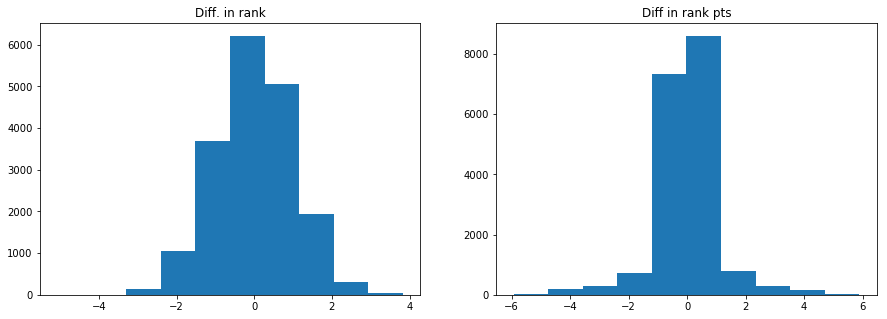

In [1945]:
# define figure and axes
fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

ax0.hist(features['age'].dropna())
ax0.set_title('Diff. in rank')
ax1.hist(features.rankpts.dropna())
ax1.set_title('Diff in rank pts')

### Future Work

** Proposed features:**

*  percent of winning tie-breakers 
*  percent of `upsets` (losing when higher ranked, winning when lower ranked)
*  percent head-to-head victories (against the same player)


** Parameters to solve for:**

* Time discount factor over historical averages
* Match weighting factor.  Issues include:   
    -heads-to-heads  
    -common opponents  
    -court surface 
    
** Take-aways:**

1.  **rank is not the whole picture**   
    -Ex:  David Nalbandian has gone 8-11 against Federer, in spite of being lower ranked
2.  **the data is messy**  
    -incomplete matches  
    -missing data  
    -incorrect data
3.  **informative features need to be constructed**  
    -infering injury  
    -head-to-head history
    
   
